農研機構メッシュ農業気象データシステム(AMGSDS) 　ドキュメント<br>
チュートリアル　６ 発育の予測

# 発育の予測
　農作物は、芽が出る、花が咲く、実が熟すなど、段階（フェノロジー）を踏んで成長します。農作物につく虫も、孵化する、脱皮するなどまた然りです。このチュートリアルでは、DVR/DVS法と呼ばれる、生物の発育を予測する方法を学びます。

　まず、以下のセルを実行し、このチュートリアルで使用するライブラリと、描画関数、有効積算気温型のDVR関数を読み込んでください。<br>
（実行後は、左端の青太線をクリックして畳んでおいてください）

In [ ]:
# このチュートリアルで使用するライブラリ
# ライブラリ（メッシュデータ処理のために必要）
#from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import xarray as xr
import AMD_Tools3 as amd
# ライブラリ（分布図描画関数で必要）
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib.colors import Normalize
#plt.rcParams['font.family'] = 'Meiryo'  # Windows PC の場合、この行を有効にすると日本語が使えます
# 関数
def drawmap(arr,lat,lon,scl=None,figtitle='',filename=None,cmap='Spectral_r') :
    # 図の大きさ等の設定
    tate = 4      #図を入れるオブジェクト(入れ物)の全体的な大きさを指定します。
    yoko = tate * (np.max(lon)-np.min(lon))/(np.max(lat)-np.min(lat))
    fig, ax = plt.subplots(figsize=(yoko,tate))
    ax.set_facecolor('0.8')
    ax.set_title(figtitle)
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    # カラースケールの設定
    cm=eval('plt.cm.'+cmap)
    #cm.set_under('black')
    #cm.set_over('white')
    # 図の生成
    if scl==None:
        mp = ax.pcolormesh(lon, lat, arr, cmap=cm)
        cbar = fig.colorbar(mp) 
    else:
        levels = np.arange(scl[0],scl[1]+scl[2],scl[2])
        mp = ax.pcolormesh(lon, lat, arr, cmap=cm, norm=Normalize(vmin=scl[0], vmax=scl[1]))
        cbar = fig.colorbar(mp,extend='both')
        cbar.set_ticks(levels)
    cbar.set_label('') 
    if type(filename) == str: # 図の出力
        fig.savefig(filename, dpi=600)
        plt.show() #表示

def DVR(Ta, Para=[10.0, 1000.0]):
    '''
    積算温度型の発育速度関数。
    引数(必須)：
      Ta：日平均気温
    引数(必要に応じ設定)  
      Para:基準温度(「生長ゼロ点」とも、これ以下の場合積算をしない) と 出穂到達積算温度 
    　　　　のリスト。デフォルト値として[10, 1000]が設定されている。
    戻り値：気温に対する発育速度値
    '''
    if Para[0] < Ta:
        DVR = (Ta-Para[0])/Para[1] #（平均気温ー基準温度）/出穂到達積算温度
    else:
        DVR = 0.0
    return DVR 

## 1 DVR/DVS法
　農業現場で行われる発育予測の殆どは、**DVR/DVS法** で行われています。これは、作物や害虫の発育を以下の考え方で予測しようとするものです。

1. 生物は、日々発育する
1. 日々の発育の速度（これを **DVR** と呼ぶ）は、周囲の気温等、気象量の関数で与えることができる
1. 出穂のような生物の現象は、日々の発育を積算したもの（これを **DVS** と呼ぶ）の値が一定値に達したときに生起する
1. 同じ現象であっても、発育速度は種・品種によって異なる

　なお、よく知られる **有効積算気温法** は、DVR/DVS法に含まれるものです。

## 2 発育速度関数
　生物の発育の活発さを気象量の関数で表現したものが **発育速度関数(DVR関数)** です。様々な生物の様々な現象に対応するため、数種類の基本的な関数と数個の調整係数(パラメータ)を組み合わせて使われます。一般的には、「水稲の出穂」や「カイガラムシの孵化」などの生命現象毎に、それに適した関数を設定し、品種や種などに対してパラメータを設定するという使い方がされます。<br>
　なお、**DVR 関数** は、あくまで、仮想的な量なので、１や２など切りのよい数字がフェノロジーに達する **DVS 値** となるように（「DVSが1になったら出穂である」などのように）設定されるのが一般的です。

　以下に２種類の DVR 関数の関数定義の例を示します。<br>
　まず最初は、有効積算気温法と等価な DVR 関数です。この関数は、基準温度(成長ゼロ点などとも)と呼ばれる温度の値よりも日平均気温が高い日にのみ発育し、気温が高ければ高いほど直線的に成長も進むとする関数です。Pythonのコードにしたものを下に示します。この例では、基準温度と積算気温をキーワード引数に与えるようにし、デフォルト値をそれぞれ 10.0 度、1000 度に設定してコーディングされています。

In [ ]:
# １ 有効積算気温法と等価なDVR関数

def DVR(Ta, Para=[10.0, 1000.0]):
    '''
    積算温度型の発育速度関数。
    引数(必須)：
      Ta：日平均気温
    引数(必要に応じ設定)  
      Para:基準温度(「生長ゼロ点」とも、これ以下の場合積算をしない) と 出穂到達積算温度 
    　　　　のリスト。デフォルト値として[10, 1000]が設定されている。
    戻り値：気温に対する発育速度値
    '''
    if Para[0] < Ta:
        DVR = (Ta-Para[0])/Para[1] #（平均気温ー基準温度）/出穂到達積算温度
    else:
        DVR = 0.0
    return DVR 

　次に示すのは、より複雑なもので、①ある気温以下では発育しない、②それより高い気温範囲では高ければ高いほど早く発育する。③さらに高い気温範囲では、発育の早さは頭打ちとなり気温によらず一定、④もっと高い気温範囲では、気温が高くなると逆に発育が遅くなる。⑤それよりもさらに気温が高いと発育しない。というタイプのもので、折れ線で台形を繋いだような形の関数です。

　なお、ここでは例を示しませんが、発育速度関数には、気温に加え **日長** も変数として使用するものもあります。

In [ ]:
# ２ 連結する折れ線で表現されるDVR関数

def DVR_(Ta):
    '''
    連結する折れ線で表現される発育速度関数
    このタイプは、品種特性込みの実験式として作成されることが多い。
    これは、5本の折れ線で構成される場合のサンプル。 elif文を増やせば
    折れ線の数を増やすことができる。
    引数(必須)：
      Ta：日平均気温
    戻り値：気温に対する発育速度値
    '''
    if Ta <= 0:
        return 0.0
    elif Ta <= 6.0 :
        return 0.0002 * Ta
    elif Ta <= 9.0 :
        return 0.0012
    elif Ta <= 12.0:
        return 0.0012-0.0004*(Ta-9)
    else:
        return 0.0


## 3 発育予測の基本形
　DVR/DVS法を用いて、以下の条件で水稲の出穂日を予測します。
* DVR関数に有効積算気温型を用いる
* 基準温度は10℃、積算温度は1050℃・日とする
* 北緯36.0566度、東経140.125度（茨城県つくば市内）で栽培されているとする
* 移植日は2023年5月10日とする

　理解の助けとするため、期間中の 気温、DVR、DVS の推移を下図に示します。
 
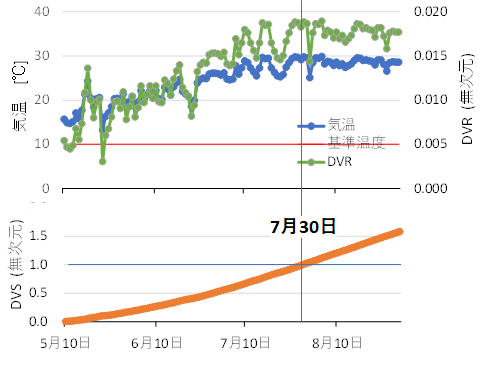

　まず、日平均気温を取得しましょう。移植日が5月10日なので、期間の開始日は5月10日にします。どんなに遅くとも9月じゅうには出穂するでしょうから、期間の終了日は9月30日とします。

In [ ]:
# 気象データの取得
nani = 'TMP_mea'
itsu = ['2023-05-10', '2023-09-30']  # 移植日から、まあそれまでには出穂するでしょうという日まで
doko = [36.0566, 36.0566, 140.1250, 140.1250]
data, tim, lat, lon = amd.GetMetData(nani, itsu, doko)
Ta = data[:,0,0] 

　次に、基本的設定として、DVR関数のパラメータ（基準温度と積算温度）を設定します。

In [ ]:
# 基本的設定
para = [10.0, 1050.0]  # 基準温度は10℃、積算温度は1050℃・日

　「 i 日目の気温 Tai からその日の DVR を計算して DVS に加える 」という処理を、DVS が１を超えるまで繰り返すことで出穂日を予測します。

In [ ]:
# 出穂の計算
DVS = 0.0
for i, Tai in enumerate(Ta):  # iに'日目'が、Taiにi日目の気温が順次渡される
    DVS += DVR(Tai,Para=para)   # i日目(が終わった時)におけるDVS
    print(i,Tai,DVS)
    if DVS > 1.0 : # DVSが1を超えたら
        break      # ループを終了
# 結果の表示
print('出穂日: ', tim[i])

　このスクリプトでは、「 **i 日目の気温 Tai からその日の DVR を計算して DVS に加える** 」という繰り返し処理を **for 文** で行い、for ブロック中に、「DVS が 1 になったら for ブロックから抜け出せ」という指示を if 文で入れて、出穂日になった時点で繰り返し計算を強制的に終了させています。<br>
　そして、（= **tim[0]**）から繰り返し計算をして i 番目の気温データで１を超えたのであれば、その日の日付は、**tim[i]** なので、これを出穂日としています。<br>

　Python の for 文では、**in** の右側に置いたイテレータ（この場合は １次元配列 **Ta** ）の要素が順次 **in** の左側に置いた変数（この場合は **Tai** ）に代入されて for ブロックが実行されますが、イテレータを関数 **enumerate** に入れた形で置くと、要素だけでなく、そのインデックス（何番目の要素であるか）も同時に与えられます。今回は、気温データだけでなく、出穂日を同定するためにインデックスも使用するので、この関数を使用しました。

　また、for 文は、本来は、指定された回数実行して円満に終了するためのものであり、このような使用法は少し邪道ですが、想定した時期になっても出穂しなかった場合に、与えた気象データの最後の日が出穂日として'円満'に返されエラーが発生しません。一般的には、想定外のことが発生したときは処理を中断した方がよいですが、発育予測に関連しては、なまじエラーで停止するよりもこちらの方が何かと便利なので、敢えて for で繰り返し計算をさせています。

　なお、この例では、積算を開始する DVS の初期値を0と置きましたが、育苗条件に応じて0.1等に設定して予測するすることもあります。

## 4 発育の分布図
　農業現場では、各生産者の管理を支援する目的で、県下の水稲の出穂日や果樹の開花日の予測分布図を作成することがあります。このような例として、水稲の出穂日数(移植日からの日数)を、以下の条件で推定し分布図とするケースを考えます。
* 有効積算気温法（基準温度10℃、積算温度1050℃）で推定する
* 対象は、茨城県の水田が分布する３次メッシュ
* 移植日は、領域一律に2023年5月10日とする 
 このような予測分布図をメッシュ農業気象データで作成する上でのテクニックを説明します。

　面的な推定は、以下２項目の準備をしたうえで、_3_ 章 で行ったのと同じ計算を、メッシュごとに何度も繰り返せば実行できます。
 
1.  計算対象とするメッシュのリストアップ
1. それぞれのメッシュにおける出穂日数を記録するための配列の用意

　まず最初に、気象データを取得します。

In [ ]:
# 気象データの取得
nani = 'TMP_mea'
itsu = ['2023-05-10', '2023-09-30'] 
doko = [35.733,36.950, 139.690,140.860]  # 茨城県がすっぽり入る大きさ
data, tim, lat, lon = amd.GetMetData(nani, itsu, doko)

　１項目目は以下のようにします。

In [ ]:
prf, lat, lon = amd.GetGeoData('pref_0800', doko) # 県域データ
lu01,lat,lon  = amd.GetGeoData('landuse_H210100', doko)  # 「田」の比率データ
pad = np.where(lu01>0.0, 1, np.nan)  # 田が少しでもあれば1,全くなければ無効値の配列
met = np.where( ~np.isnan(data[0,:,:]), 1, np.nan) # 気象データがあれば１なければ無効値の配列
val = prf * pad * met
yy,xx = np.where(val == 1) # 計算対象のインデックス(要素の番号)

print(yy)
print(xx)

　復習になりますが、上の yy と xx とから１つずつ要素を取り出してそれぞれ緯度方向のインデックスと経度方向のインデックスとした配列要素が、計算対象のメッシュです。具体的には、[2,88]、[2,89]、[3,86]、・・・、[144,72]、[145,70]、[145,71] が計算対象のメッシュです。

　項目２については、以下のようにします。

In [ ]:
# 出穂日数を記録するための配列を新規作成
hd = val * np.nan  # 手抜きの方法

　これでループ処理をする材料が整いました。
 
　ループにおいては、インデックスの配列 **yy** と **xx** から１つずつ取り出して **Y** と **X** に代入し、それに基づいて処理対象のメッシュの気象データを1次元の形で取り出します。２個の変数を同時に取り出すので、for 文に関数 **zip** を用います。<br>
　このforループの中に、**DVS** を積算するためのforループをもう一段深く置きます。<br>
　DVS が1を超えてこのループを脱したらこのループを抜け、1を超えたときの **i** (これが出穂日数)を **hd[Y,X]** 保存します。

In [ ]:
para = [10.0, 1050.0]  #基準温度は10℃、積算温度1050℃・日

for Y, X in zip(yy,xx):
    Ta = data[:,Y,X]  # m番目に順序づけられたメッシュにおける全期間の気温
    #出穂日計算
    DVS = 0.0 #移植時の発育指数
    for i, Tai in enumerate(Ta):  # iに'日目'、Taiにi日目の気温が順次渡される
        DVS += DVR(Tai,Para=para)   # i日目(が終わった時)におけるDVS
        if DVS > 1.0 : #DVSが1を超えたら
            break
    hd[Y,X] = i
    
# 描画
drawmap(hd,lat,lon)
# 地理院地図上に表示するファイルの作成
amd.PutGSI_Map(hd, lat, lon, 
               label='Number of days from 2023-05-10',
               filename="heading")

## 5 条件が異なる多数の発育予測
　栽培試験の管理に、発育予測を使うケースを考えます。栽培試験では、いくつかの拠点で、多様な栽培期間や管理で、多数の品種を、栽培するのが普通で、試験の総数は相当な数に及びます。このようなケースのプログラミングでは、以下2点につき工夫が必要です。
* CSVファイルにまとめられている栽培条件を読み込んで順次処理が行えること
* 処理の度にデータを取得するのではなく、再利用できる気象データは再利用すること

### 5.1 栽培条件の読み込み

　栽培試験の整理表に緯度経度や発育パラメータを付随させることは通常はありませんが、簡単のため、以下のように、栽培地点名の緯度経度、品種名や品種パラメータなど計算に必要な情報は全部一つの表にマージされている場合で考えます。

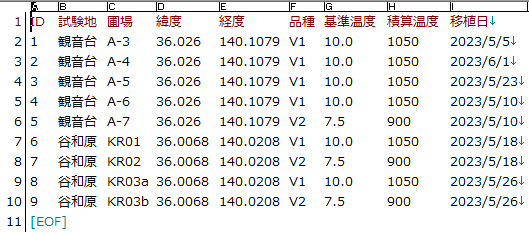

　まず最初に、CSVファイルを読み込みます。方法については、チュートリアル５「CSVファイルの読み書き」で学習しました。ここでは、読み込んだデータを実際に利用します。

In [ ]:
xp = pd.read_csv('5_CSVファイルの読み書き_読み込みサンプル.csv',  # ファイル名
                 encoding='Shift_JIS',   # 文字コード（Excelやネットから取得したものはほぼシフトJIS）
                 parse_dates=['移植日'],  # 日付と理解できる文字列は日付と見なす
                )
xp

### 5.2 栽培条件を網羅する気象データの取得

　データが pandas.DataFrame オブジェクト **xp** として読み込まれました。次に、これに基づいて、取得する気象データを、個々の予測が必要とするであろう時空間範囲を全て含む形で定めます。

　期間について、開始日は 「移植日」 の列の最小値をとればよいでしょう。メソッド **min** を使えば簡単に取り出せます。取り出された最小値はdatetimeオブジェクトなのでこれを関数 **str** で文字列に変換したうえで初めの10文字を抜き出し体裁を整えます。終了日は一概に決められませんが、9月30日であれば十分でしょう。

In [ ]:
itsu = [str(xp['移植日'].min())[:10], '2023-09-30']

print('itsu =', itsu)

　領域については、全ての試験圃場が含まれる範囲を指定します。「緯度」、「経度」それぞれの列の数値の最小値と最大値を与えればよいでしょう。以下のスクリプトでしめすように、最小値や最大値は、メソッド **min** やメソッド **max** で取り出すことができます。

In [ ]:
doko = [xp['緯度'].min(), xp['緯度'].max(), xp['経度'].min(), xp['経度'].max()]

print('doko =', doko)

　この **itsu** と **doko** で、気象データを取得します。 

　なお、「すべての試験圃場含まれる範囲」として、都府県、ないしは、総合振興局程度の広さを想定しています。本州レベルのスケールの場合は、個々に分割してください。

In [ ]:
# 気象データの取得
nani = 'TMP_mea'
data,tim,lat,lon,nam,uni = amd.GetMetData(nani,itsu,doko,namuni=True)

### 5.3 個々の栽培条件に対する気象データの取り出し

　取得した気温データは全時空間域をカバーする気象データなので、個々の発育予測においては、それぞれの期間、緯度経度のデータをこの中から取り出さなければなりません。<br>
　numpy.ndarrayオブジェクトの配列は、指定した要素や範囲のデータをインデックスで指定して取り出すことができますが、そのインデックスを見つけるのは結構面倒です。特に、緯度経度に関しては、一般に試験圃場の緯度経度はメッシュの中心緯度とは異なるので、「最も近い」という工夫の上で探さなければなりません。このコーディングはとても面倒なので、Python のライブラリ **xarray** の力を借りて行います。<br>
　xarray は、比較的新しいライブラリーですが、地球科学分野を中心に急速に利用が広がっています。多次元データ本体と、それが準拠する時間、緯度、経度、高度などの次元座標、名称、単位などの属性情報を丸ごと保持する **DataArray** と呼ばれるオブジェクトを提供し、このオブジェクトには、解析に便利な多数のメソッドが用意されています。特に、座標値を指定して、一致、あるいは最も近いデータを取り出すメソッド **sel** は大変便利なので、これを利用します。ライブラリ **xarray** の概要については、以下のURLで確認してください。<br>
https://xarray.dev/

　メッシュ農業気象データは、格子点データではなく、メッシュデータですが、データ形式としては格子点データとして扱えるので、DataArray オブジェクトにできます。<br>
　以下を実行すると、**tim**, **lat**, **lon**, **nam**, **uni** とばらばらになっているメッシュデータを一つの、DataArray オブジェクト **mdarr** に纏めることができます。

　実行してください。<br>
　(表示の左上のお皿が重なったようなアイコンをクリックすると表示が畳まれ全体が見やすくなります) 

In [ ]:
# 取得した気象データから DataArrayオブジェクト mdarr を作成
mdarr = xr.DataArray(data,    
                     dims=['tim','lat','lon'],
                     coords=[('tim', tim), ('lat', lat), ('lon', lon)],
                     name=nani,
                     attrs={'long_name':nam,'units':uni},
                    )
mdarr

　これで、気象データは DataArrayオブジェクト **mdarr** となったので、メソッド **sel** を以下のように使用することで、個々の予測計算で必要となる気象データを取り出すことができます。
```Python
mdarr.sel(lat=exlat,lon=exlon,method='nearest').sel(tim=slice(extim,None))
```
 これを **for** ループの中に置けば、個々の発育予測に使う気象データが順次得られます。以下でそれを確認できます。

In [ ]:
for idx in xp.index:  # Excelで言う行番号でループを回す
    para = list(xp.loc[idx,['基準温度','積算温度']])
    exla = xp.at[idx,'緯度']
    exlo = xp.at[idx,'経度']
    exti = xp.at[idx,'移植日']
    Tarr = mdarr.sel(lat=exla,lon=exlo,method='nearest').sel(tim=slice(exti,None)) # 指定した緯度経度に最も近いメッシュの気象データを取り出す
    # 確認のための表示をする文
    print('インデックス', idx, ':')
    print('品種パラメータ：', para)
    print('気象データ：', Tarr.data)
    print()    

　これで、DVSを計算する準備が整いました。

### 5.4 発育予測の連続的実行

　上の **for** ループの中に、発育予測をするDVSを積算する **for** ループをさらに組み込めば,
 個々の試験の条件に応じた発育予測を行うことができます。

In [ ]:
for idx in xp.index:
    para = list(xp.loc[idx,['基準温度','積算温度']])
    exla = xp.at[idx,'緯度']
    exlo = xp.at[idx,'経度']
    exti = xp.at[idx,'移植日']
    Tarr = mdarr.sel(lat=exla,lon=exlo,method='nearest').sel(tim=slice(exti,None)) # 指定した緯度経度に最も近いメッシュの気象データを取り出す
    #出穂の計算
    DVS = 0
    for i,Tai in enumerate(Tarr.data):  # 個々の栽培条件におけるi日目の気温がTaiに代入される
        DVS += DVR(Tai, para)   # i日目(が終わった時)におけるDVS
        if DVS > 1.0 : # DVSが1を超えたら
            break      # ループを終了
    # 結果の表示
    print('出穂日: ', Tarr.tim[i].data)    

　仕上げとして、結果を表示ではなく、CSVファイルとして出力させます。

　それには、オブジェクト **xp** に新しい列 「**出穂日**」 を追加したうえで、計算結果をここに記録し、最後に、メソッド **to_csv** でCSV ファイルとして出力します。この際、書き出す列を取捨選択します。
 
　以下を実行すると、ファイル **予測結果.csv** が作られます。

In [ ]:
xp['出穂日'] = xp['移植日']  # 表xpに列「出穂日」を追加（やっていることは列コピー＆見出し名変更）

for idx in xp.index:
    para = list(xp.loc[idx,['基準温度','積算温度']])
    exla = xp.at[idx,'緯度']
    exlo = xp.at[idx,'経度']
    exti = xp.at[idx,'移植日']
    Tarr = mdarr.sel(lat=exla,lon=exlo,method='nearest').sel(tim=slice(exti,None)) # 指定した緯度経度に最も近いメッシュの気象データを取り出す
    #出穂の計算
    DVS = 0
    for i,Tai in enumerate(Tarr.data):
        DVS += DVR(Tai, para)
        if DVS > 1.0 :
            break
    # 表 xp への結果の書き込み
    xp.at[idx,'出穂日'] = str(Tarr.tim[i].data)  # 文字列を経由でdatetime64→Timestamp

# ファイル出力
xp.to_csv('予測結果.csv',
            columns=['ID','試験地','圃場','品種','移植日','出穂日'], 
            encoding="Shift_JIS",
            index=False)
    

　上のスクリプトにおいて、1行目の文が「出穂日」を追加する文ですが、少々トリッキーな取り回しなので説明しておきます。pandasのDataFrameでは、代入式の左辺に既存の列が指定されると、その列に右辺の値が代入されますが、新しい列名が指定されるとその名前の列が新規に追加され、そこに右辺の値が代入されます。つまり1行目の文のようにすると、DataFrame **xp** に新しい列「出穂日」が追加され移植日のデータがコピーされます。もちろん、この日付は出穂日ではないのですが、列の追加という目的は達成されました。日付については、11～16 行目で計算され 18 行目の代入文で順次修正されます。<br>
　ファイル出力においては、オブジェクト **xp** の列全てを出力するのではなく、「ID」「試験地」「圃場」「品種」「移植日」「出穂日」に限定しています。


In [ ]:
xp